In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

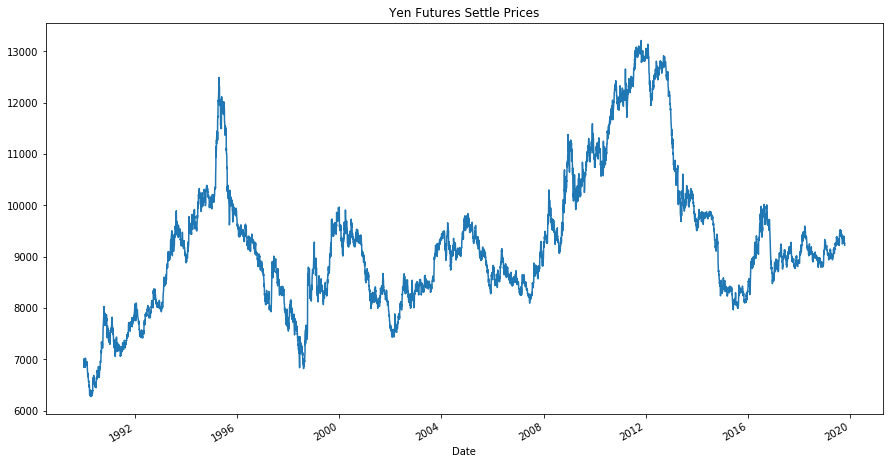

In [5]:
# Plot just the "Settle" column from the dataframe:

yen_futures.Settle.plot(title='Yen Futures Settle Prices', figsize=(15,8))

Based on the plot, there appears to by a cyclical, although upward, trend of the yen's value in relation to the dollar. Given a shorter time horizon, it might prove difficult to forecast the yen's performance, as there is significant variance; however, there appears to be an overal upward trend when observed over decades.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

yen_settle = pd.DataFrame(yen_futures['Settle'])
yen_settle['noise'] = ts_noise
yen_settle['trend'] = ts_trend
yen_settle.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


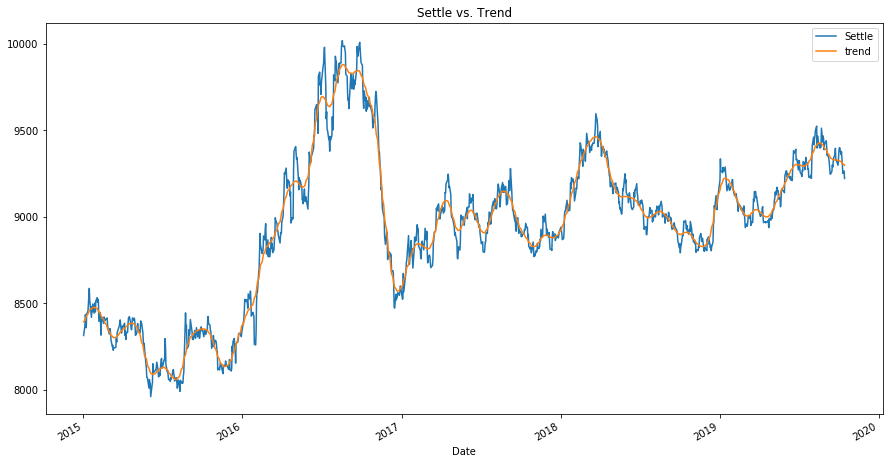

In [8]:
# Plot the Settle Price vs. the Trend

yen_settle.loc['2015':].plot(title='Settle vs. Trend', y=['Settle', 'trend'], 
    figsize=(15,8))

Applying the HP filter makes the upward trend over time clear, making the yen seem to be an attractive long-term investment. There also appear to be frequent short-term fluctuations, demonstrated by the noise, that allow for the possibility for profitable trading opportunities.

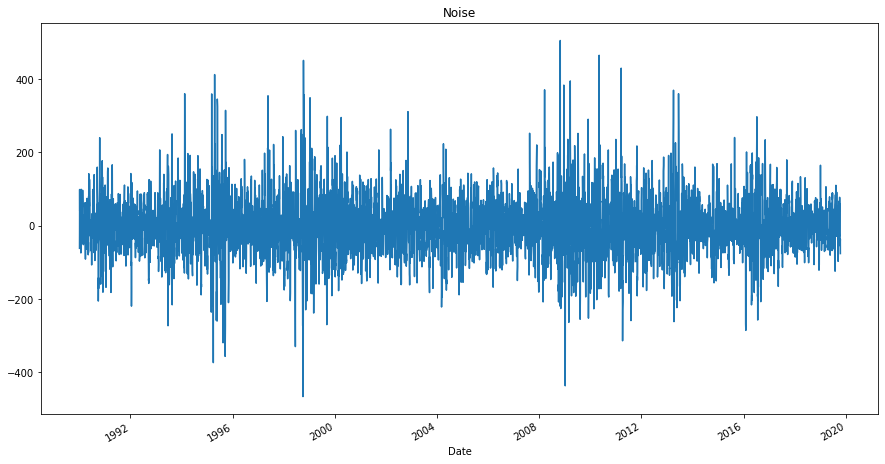

In [9]:
# Plot the Settle Noise

yen_settle.noise.plot(title='Noise', figsize=(15,8))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [11]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))

model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results

results = model.fit()

In [12]:
# Output model summary results:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 07 Mar 2020   AIC                          15798.142
Time:                        14:16:48   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.278      0.231      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.1918           +0.0000j          157.1918            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

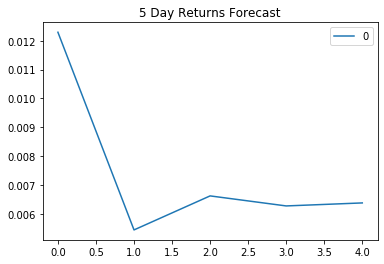

In [13]:
# Plot the 5 Day Returns Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Returns Forecast')

Question: Based on the p-value, is the model a good fit?

Answer:

The p-values are high (over 10 times 0.05), which indiates that this model is probably not a good fit.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

model_arima = ARIMA(yen_futures['Settle'].values, order=(5,1,1))

# Fit the model

results_arima = model_arima.fit()

In [15]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 07 Mar 2020   AIC                          83905.238
Time:                        14:17:04   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.y      0.2823      0.699      0.404      0.686      -1.088       1.653
ar.L2.D.y      0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3786j            2.3409           -0.1002
AR.2            1.8920           +1.3786j            2.3409            0.1002
AR.3           -2.2711           -3.0199j            3.7785           -0.3526
AR.4           -2.2711           +3.0199j            3.7785            0.3526
AR.5          -11.1033           -0.0000j           11.1033           -0.5000
MA.1            3.3632           +0.0000j            3.3632            0.0000
-----------------------------------------------------------------------------
"""

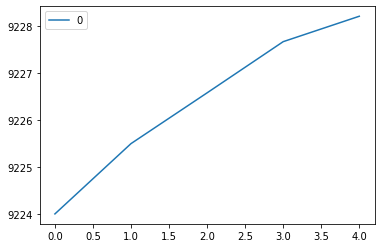

In [16]:
# Plot the 5 Day Price Forecast

pd.DataFrame(results_arima.forecast(steps=5)[0]).plot()

What does the model forecast will happen to the Japanese Yen in the near term?

This model indicates an increase in the volatility of the yen over the next 5 days.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [17]:
import arch as arch

In [18]:
# Estimate a GARCH model:

model_garch = arch.arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1)

# Fit the model

res = model_garch.fit(disp="off")

In [20]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Sat, Mar 07 2020   Df Residuals:                     7511
Time:                        14:17:27   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [22]:
# Create a 5 day forecast of volatility

forecast_horizon = 5

# Start the forecast using the last_day calculated above

forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [23]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [24]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


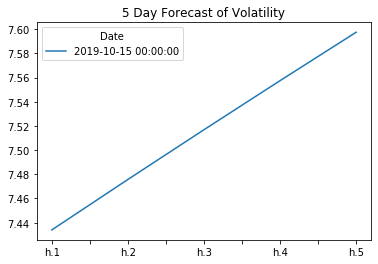

In [25]:
# Plot the final forecast

final.plot(title='5 Day Forecast of Volatility')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Based on the yen futures settle price plot, there appears to be a trend that indicates the strenghtening of the yen in relation to the dollar over a long time horizon. Therefore, I would recommend the purchase of the yen if my client has a long strategy. However, given the forecasted increase in volatility over the coming days, the yen seems to be a relatively risky short-term investment. If my client is looking for short-term reliable gains, I would probably not recommend an investment in the yen based on the given data.

The only model I would feel confident implementing for trading using the given data would be GARCH. The GARCH model is the only one with a p-value under 0.05, while the AMRA and ARIMA models had p-values that are over 10 times 0.05. Additionally, the GARCH model's AIC is the lowest of all three.